In [207]:
import pandas as pd
import sys
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.insert(0, '../../')

# read in data

In [243]:
original_df = pd.read_csv('../../data/imbalance_data/cleaned_08-01-2020_22_15_47 - 08-01-2020_22_15_47_355pm_data.csv')

In [244]:
original_df

,symbol,currentvolume,lastprice,nbb,nbo,imbside,imbalancesize,notional_imbalance,imbalancetype,matchedsize,...,farindicativeprice,matched_to_unmatched,close,pct_move_snapshot_to_close,minute,day,quarter,year,week,month
0,1,2370571,198.310,198.39,198.39,1,39056,7745195.36,0,244690,...,197.09,0.159614,198.35,0.02,55,27,3,2019,35,8
1,5,4476596,112.540,112.56,112.56,0,9542,1073856.68,0,698225,...,113.59,0.013666,112.42,-0.11,55,27,3,2019,35,8
2,10,2118756,218.290,218.29,218.29,0,128460,28041533.40,0,895156,...,222.51,0.143506,218.21,-0.04,55,27,3,2019,35,8
3,15,4733027,134.250,134.28,134.30,1,95146,12773350.50,0,428735,...,127.19,0.221923,134.49,0.18,55,27,3,2019,35,8
4,19,1072811,89.385,89.36,89.39,1,2206,197183.31,0,11094,...,89.24,0.198846,89.37,-0.02,55,27,3,2019,35,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6728,991,1155034,14.900,14.90,14.91,0,86941,1295420.90,0,704511,...,15.21,0.123406,14.82,-0.54,55,26,2,2020,26,6
6729,992,9459644,14.715,14.71,14.72,0,97820,1439421.30,0,1137053,...,15.75,0.086029,14.69,-0.17,55,26,2,2020,26,6
6730,306,823001,96.430,96.37,96.47,0,6119,590055.17,0,608029,...,0.00,0.010064,96.67,0.25,55,26,2,2020,26,6
6731,942,1243096,42.320,42.32,42.33,1,5199,220021.68,0,258729,...,39.45,0.020094,42.29,-0.07,55,26,2,2020,26,6


In [245]:
original_df.drop('imbalancetype', inplace=True, axis=1)

In [246]:
# p_and_l_df = original_df[['close', 'lastprice_unnormalized']] # use this for p&l
p_and_l_df = original_df[['close', 'lastprice']] # use this for p&l

In [247]:
imbal_train_df = original_df.loc[:, (original_df.columns!='close') &  (original_df.columns!='lastprice_unnormalized') ]

# take top cols
- need to run all cells first

In [248]:
cols_to_select = list(X_train.columns[np.array(lr.coef_ > .000005).ravel()])

In [249]:
lr.coef_

array([[ 0.46535029, -0.46600245,  0.0187135 ,  0.00999552]])

In [250]:
cols_to_select.append('pct_move_snapshot_to_close')
smaller_imbal_train_df = imbal_train_df.loc[:,imbal_train_df.columns.isin(cols_to_select)]

In [251]:
cols_to_select

['nbo', 'day', 'month', 'pct_move_snapshot_to_close']

# split into x and y

In [252]:

imbal_train_X = imbal_train_df.loc[:, imbal_train_df.columns != 'pct_move_snapshot_to_close']
imbal_train_y = imbal_train_df.loc[:, imbal_train_df.columns == 'pct_move_snapshot_to_close']

In [253]:
imbal_train_y

,pct_move_snapshot_to_close
0,0.02
1,-0.11
2,-0.04
3,0.18
4,-0.02
...,...
6728,-0.54
6729,-0.17
6730,0.25
6731,-0.07


In [254]:
# # small cols

# imbal_train_X = smaller_imbal_train_df.loc[:, smaller_imbal_train_df.columns != 'pct_move_snapshot_to_close']
# imbal_train_y = smaller_imbal_train_df.loc[:, smaller_imbal_train_df.columns == 'pct_move_snapshot_to_close']

# train a model

In [348]:
np.sum(np.abs(test_predictions) > .5)

8

In [377]:
mae = []
mae_above_threshold = []
mae_positive_predictions = []
mae_negative_predictions= [] 
n_correct_signs=[]

n_correct_sign_and_more_extreme_predictions = []
n_correct_sign_and_threshold = []
total_delta_close_last = []
len_correct=[]
threshold = .5
cv = 120

position_size_in_dollars=100_000
cost_per_1k_shares_entry_and_exit=6
n_positions_entered=0
n_total_positions=0
# How much does it cost per share?
# $6 per 1k shares on entry and exit

start_prices_running_sum = 0
end_prices_running_sum = 0 # this should be higher

start_prices_correct=0
end_prices_correct=0 # this should be higher
    
for i in range(cv):
    if i % 20 == 0:
        print(f"PCT finished = {i/cv:.2%}")
    lr =LinearRegression()
    X_train, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.20) # RandomForestRegressor(n_jobs=-1) #ain, X_test, y_train, y_test  = train_test_split(imbal_train_X, imbal_train_y, test_size=0.10)
    p_and_l_test_df = X_test.join(p_and_l_df, lsuffix='_left')
    
    
    lr.fit(X_train, y_train )

    test_predictions = lr.predict(X_test)
    mae.append(mean_absolute_error(y_test, test_predictions) )

    # what about more extreme predicitons, above threshold
    threshold_mask = np.abs(test_predictions) > threshold
    threshold_test_predictions = test_predictions[threshold_mask]
    threshold_y_test = y_test[threshold_mask]
    try:
        mae_above_threshold.append(mean_absolute_error(threshold_y_test, threshold_test_predictions))
    except:
        pass

    # are we better at positive or negative predictions?
    positive_mask = np.sign(test_predictions) == 1
    positive_predictions = test_predictions[positive_mask]
    positive_y_test = y_test[positive_mask]
    mae_positive_predictions.append(mean_absolute_error(positive_y_test, positive_predictions))

    negative_predictions = test_predictions[np.sign(test_predictions) == -1]
    negative_y_test = y_test[np.sign(test_predictions) == -1]
    mae_negative_predictions.append(mean_absolute_error(negative_y_test, negative_predictions))

    # sign of prediction and more extreme signs
    len_correct.append(len(y_test))
    n_sign_and_extreme = []
    n_sign = []
    n_sign_and_threshold = []
    delta_close_last_array = []
    
    
    prediction_index = 0
    for pred_, true_ in zip(test_predictions, np.array(y_test).ravel()):
        # what if we got 100% of predictions correct
        if np.sign(true_) > 0:
            start_prices_correct+= p_and_l_test_df.iloc[prediction_index, :]['lastprice'] 
            end_prices_correct+= p_and_l_test_df.iloc[prediction_index, :]['close']
        else: # going down
            end_prices_correct+= p_and_l_test_df.iloc[prediction_index, :]['lastprice']   #['lastprice_unnormalized']
            start_prices_correct+= p_and_l_test_df.iloc[prediction_index, :]['close']
            
        n_total_positions += 1

        if (np.sign(pred_) == np.sign(true_) ) and (np.abs(true_) > np.abs(pred_)):
            n_sign_and_extreme.append(1)
        if (np.sign(pred_) == np.sign(true_) ) :
            n_sign.append(1)
        if (np.abs(pred_) > threshold) and (np.sign(pred_) == np.sign(true_) ) : 
            n_sign_and_threshold.append(1)
            
        if (np.abs(pred_) > threshold): ## get into a position here
            n_positions_entered += 1
            stock_direction_pred = np.sign(pred_) # direction stock is going to move
            
            # calculate P & l
            last_price =  p_and_l_test_df.iloc[prediction_index, :]['lastprice'] #['lastprice_unnormalized']
            
            close_price = p_and_l_test_df.iloc[prediction_index, :]['close']
            
            if stock_direction_pred > 0: # going up
                delta_close_last_pct = (close_price - last_price) / close_price
                start_prices_running_sum += last_price 
                end_prices_running_sum += close_price
                
                if (prediction_index % 200 == 0) and (i % 20 == 0):
                    print('Stock prediction direction = going up')
                    print('actual pct_move_to_close calculated=',delta_close_last_pct)
                    print('actual pvt_move_', true_)
                    print('actual pct_move_to_close=',delta_close_last_pct)
                    print('last_price at 3:50pm=',last_price)
                    print('close_price=', close_price)
                    print('prediction_index=',prediction_index)
                    print(' ')

            
            else: # going down
                delta_close_last_pct = (close_price - last_price ) / last_price
                start_prices_running_sum += close_price 
                end_prices_running_sum += last_price
                
                if (prediction_index % 200 == 0) and (i % 20 == 0):
                    print('Stock prediction direction = going down')
                    print('prediction pct_move_to_close = ', pred_)

                    print('actual pct_move_to_close calculated=',delta_close_last_pct)
                    print('actual pvt_move_', true_)
                    print('last_price at 3:50pm=',last_price)
                    print('close_price=', close_price)
                    print('prediction_index=',prediction_index)
                    print(' ')

            delta_close_last_array.append(delta_close_last_pct)
                
            
        prediction_index += 1
            
            
            
                
    n_correct_sign_and_more_extreme_predictions.append(np.sum(n_sign_and_extreme))
    n_correct_signs.append(np.sum(n_sign))
    n_correct_sign_and_threshold.append(np.sum(n_sign_and_threshold))
    total_delta_close_last.append(np.median(delta_close_last_array))



PCT finished = 0.00%
PCT finished = 16.67%
PCT finished = 33.33%
PCT finished = 50.00%
PCT finished = 66.67%
PCT finished = 83.33%


In [378]:
print(f"median mae for negative predictions = {np.median(mae_negative_predictions):.2%}")
print(f"median mae for positive predictions = {np.median(mae_positive_predictions):.2%}") # slightly better as positive predictions
print(f"median MAE with threshold predictions = {np.median(mae_above_threshold):.2%}")
print(f"median MAE with all data is {np.median(mae):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data is {np.sum(n_correct_signs)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) all data and the true data is more extreme {np.sum(n_correct_sign_and_more_extreme_predictions)/np.sum(len_correct):.2%}")
print(f"pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold \
    of {threshold} =  {np.sum(n_correct_sign_and_threshold)/np.sum(len_correct):.2%}")
print(f"The expected profit in pct per dollar  put in is {(end_prices_running_sum / start_prices_running_sum) - 1:.6%}")
print(f"The expected profit if we get every predictions correct is {(end_prices_correct / start_prices_correct) - 1:.6%}")
print(f"Pct of positions we will enter {(n_positions_entered / n_total_positions):.6%}")

median mae for negative predictions = 28.04%
median mae for positive predictions = 21.26%
median MAE with threshold predictions = 55.70%
median MAE with all data is 26.23%
pct of the time we guess the corect sign (up or down) all data is 60.82%
pct of the time we guess the corect sign (up or down) all data and the true data is more extreme 37.25%
pct of the time we guess the corect sign (up or down) and the prediction is more extreme than our threshold     of 0.5 =  0.31%
The expected profit in pct per dollar  put in is 0.272379%
The expected profit if we get every predictions correct is 0.277723%
Pct of positions we will enter 0.462138%


# Coefficients

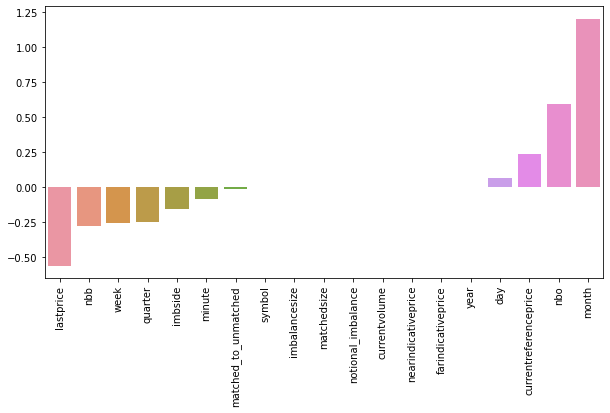

In [276]:
#unnormalized coefficients
plt.figure(figsize=(10,5))
sns.barplot(x = X_train.columns[np.argsort(lr.coef_).ravel()], y = lr.coef_.ravel()[np.argsort(lr.coef_).ravel()])
plt.xticks(rotation=90) ;

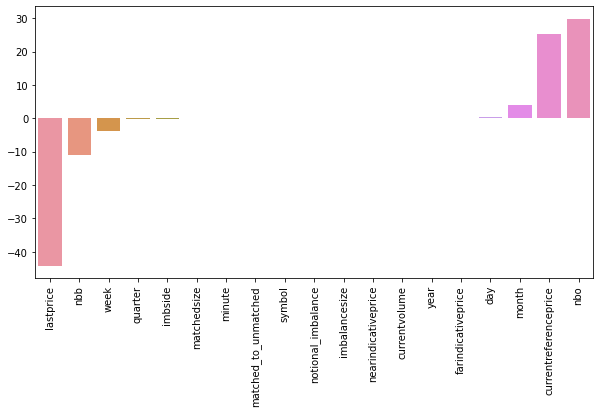

In [97]:
#normalized coefficients
plt.figure(figsize=(10,5))
sns.barplot(x = X_train.columns[np.argsort(lr.coef_).ravel()], y = lr.coef_.ravel()[np.argsort(lr.coef_).ravel()])
plt.xticks(rotation=90) ;

In [98]:
X_train.columns[np.argsort(lr.coef_).ravel()]

Index(['lastprice', 'nbb', 'week', 'quarter', 'imbside', 'matchedsize',
       'minute', 'matched_to_unmatched', 'symbol', 'notional_imbalance',
       'imbalancesize', 'nearindicativeprice', 'currentvolume', 'year',
       'farindicativeprice', 'day', 'month', 'currentreferenceprice', 'nbo'],
      dtype='object')

In [106]:
pd.DataFrame(lr.coef_.ravel()[np.argsort(lr.coef_).ravel()], X_train.columns[np.argsort(lr.coef_).ravel()], 
             columns=['coefficient value'])

,coefficient value
lastprice,-44.205370
nbb,-10.878522
week,-3.748939
quarter,-0.150459
imbside,-0.061342
matchedsize,-0.015899
minute,-0.013836
matched_to_unmatched,-0.007467
symbol,-0.004635
notional_imbalance,-0.000268
